In [1]:
import datetime
import netCDF4
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import warnings
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import cftime
import os
import seaborn as sns
import cartopy
import cartopy.feature as cpf
from global_land_mask import globe
import CMIP6_light_map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import texttable
from tqdm.notebook import trange, tqdm

In [2]:
def convert_to_180(ds):
    ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.x + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def get_area_averaged_ds(fname, model, scenario, ensemble_id, var_name, LME, create_maps, frequency, models_dict,fname2=None):
    
    if os.path.exists(fname):
        
            
        if var_name not in ["velocity"]:
            with xr.open_dataset(fname) as ds:
                ds = convert_to_180(ds)

                ds = ds.sel(time=slice(start_time,end_time)) #.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
                ds = convert_time(ds)
                if var_name in ["tas"]:
                    ds=xr.where(ds>100,ds-273.15,ds)

                ds = get_data_within_LME(ds, var_name, LME, create_maps)
                ds = ds.mean({"lat","lon"})
                df = ds.to_dataframe().dropna()

                df = df.reset_index()
            
        else:
            with xr.open_mfdataset([fname,fname2]) as ds:
                ds = convert_to_180(ds)

                ds = ds.sel(time=slice(start_time,end_time)) #.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
                ds = convert_time(ds)
                ds_uas = get_data_within_LME(ds, "uas", LME, create_maps)
                ds_vas = get_data_within_LME(ds, "vas", LME, create_maps)
                ds_uas = ds_uas.mean({"lat","lon"})
                ds_vas = ds_vas.mean({"lat","lon"})
                df = ds_uas.to_dataframe().dropna()
                df2 = ds_vas.to_dataframe().dropna()

                df = df.reset_index()
                df2 = df2.reset_index()

                df["velocity"]=np.sqrt(np.power(df["uas"], 2)+np.power(df2["vas"], 2))
                df.drop(columns=["uas","vas"], inplace=True)

        df=df.resample(frequency, on="time").mean()
        df["model_name"]=model
        df["roll_mean"]=df[var_name].rolling(5).mean().shift(-1)
        df["roll_median"]=df[var_name].rolling(5).median().shift(-1)
        df["roll_max"]=df[var_name].rolling(5).max().shift(-1)
        df["roll_min"]=df[var_name].rolling(5).min().shift(-1)

        df["model_ensemble_id"]=ensemble_id
        df["model_scenario"]=scenario
        unique="{}_{}_{}".format(model, scenario, ensemble_id)
        df["unique"]=unique

        model_info={}
        model_info["model_name"]=model
        model_info["model_scenario"]=scenario
        model_info["model_ensemble_id"]=ensemble_id
        model_info["model_var"]=var_name
        key="{}_{}_{}_{}".format(model,ensemble_id,scenario,var_name)
        formatter="{:.2f}"
        model_info["model_min"]=formatter.format(np.nanmin(df[var_name]))
        model_info["model_max"]=formatter.format(np.nanmax(df[var_name]))

        models_dict[key]=model_info

        return df, models_dict
    else:
        return None, models_dict

In [3]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]

def create_map(df, title, var_name, period, anomalies=False, details=False):
    if details is True:
        lonmin=-165
        lonmax=-143.5
        latmin=53.5
        latmax=65.0
        res="10m"
    else:
        lonmin=-252
        lonmax=-100.5
        latmin=20
        latmax=80
        res="50m"
    ax = plt.figure(figsize=(16,10)).gca(projection=cartopy.crs.PlateCarree(central_longitude=-180))

    ax.coastlines(resolution=res, linewidth=0.6, color="black", alpha=0.8, zorder=4)
    ax.add_feature(cpf.BORDERS, linestyle=':',alpha=0.4)
    ax.add_feature(cpf.LAND, color="lightgrey")
    ax.set_extent([lonmin, lonmax, latmin, latmax])

    xticks = np.linspace(lonmin, lonmax, 5)
    yticks = np.linspace(latmin, latmax, 5)

    ax.set_xticks(xticks, crs=cartopy.crs.PlateCarree())
    ax.set_yticks(yticks, crs=cartopy.crs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #if var_name in ["par"]:
    clb_label='PAR ($W/m^{2}$)'
    cs=ax.contourf(df["lon"], df["lat"], df[var_name], #np.where(df["H"] < 0, df["H"], np.nan), # df[var_name],
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())

    if title not in ["Bathymetry"]:
        clb = plt.colorbar(cs, shrink=0.5, extend="both")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    #if details:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_zoomed_{}.png".format(var_name, period), dpi=300,
    #                facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)
    #else:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_{}.png".format(var_name, period), dpi=300,
    #            facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)

    plt.show()


def create_LME_figure(ax, LMES, projection, show, extent):

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
           # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k')

            # Add the label LME_NUMBER of the selected LME at the center of the LME
          #  ax.annotate(s=LME_NUMBER,
          #              xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
          #              color="white",
          #              fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='LightGray',
                              edgecolor='k')

    if show:
        plotfile="Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')
        plt.show()

def get_data_within_LME(ds,var_name,LME,create_maps):

    print("Working on LME: {}".format(LME))
    
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
   # for name in shdf['LME_NAME']:
   #     print(name)
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Create the map of the LME bopundaries and color it.
    # The active LME has color while the others are grey.
    if create_maps:
        # Setup the figure panels
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea","Arctic Ocean"]:
            projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
            extent = [-20, 90, 60, 90]
     #       extent = [-180, 180, 60, 90]
        else:
            projection=ccrs.PlateCarree(central_longitude=-180)
            extent = [-252, -100, 10, 65]
            extent = [-200, -145, 40, 80]
        ax1 = fig.add_subplot(111, projection=projection)
    
        create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),True,extent)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    p1="2000-01-01 to 2020-01-01"
    p2="2080-01-01 to 2020-01-01"

    create_maps=False
    if create_maps:
        clipped_p1=clipped.sel(time=slice("2000-01-01","2020-01-01")).mean({"time"})
       # clipped_p2=clipped.sel(time=slice("2080-01-01","2099-12-16")).mean({"time"})

        create_map(clipped_p1, "{} 2000-01-01 to 2020-01-01".format(var_name), var_name, period=p1, anomalies=False, details=False)
        #create_map(clipped_p2, "{} 2080-01-01 to 2020-01-01".format(var_name), var_name, period=p2, anomalies=False, details=False)

        plt.show()
    return clipped

In [4]:
def create_summary_table(dict_of_models, LME):
    table = texttable.Texttable()
    table.set_cols_align(["c","c", "c","c","c","c","c"])
    table.set_cols_valign(["t","t", "m","m","m","m", "b"])

    table.header(["LME","Model", "Scenario", "ID", "Var", "CMIP6 min", "CMIP6 max"])
    for key in dict_of_models.keys():
        model=dict_of_models[key]

        table.add_row([LME,
                       model["model_name"],
                       model["model_scenario"],
                       model["model_ensemble_id"],
                       str(model["model_var"]),
                       str(model["model_min"]),
                       str(model["model_max"])])



    table.set_cols_width([30,30,20,20,10,10,10])
    print(table.draw() + "\n")

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


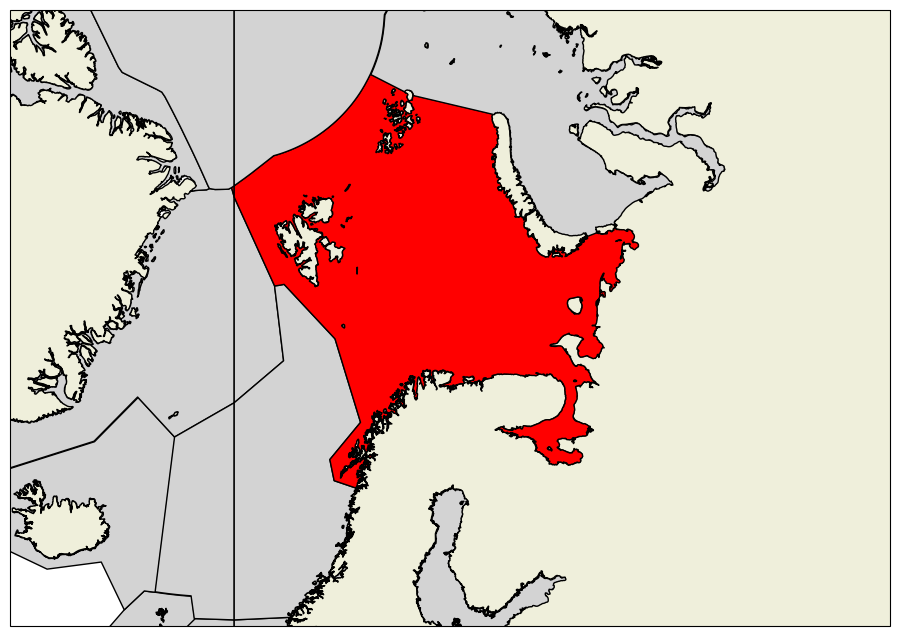

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


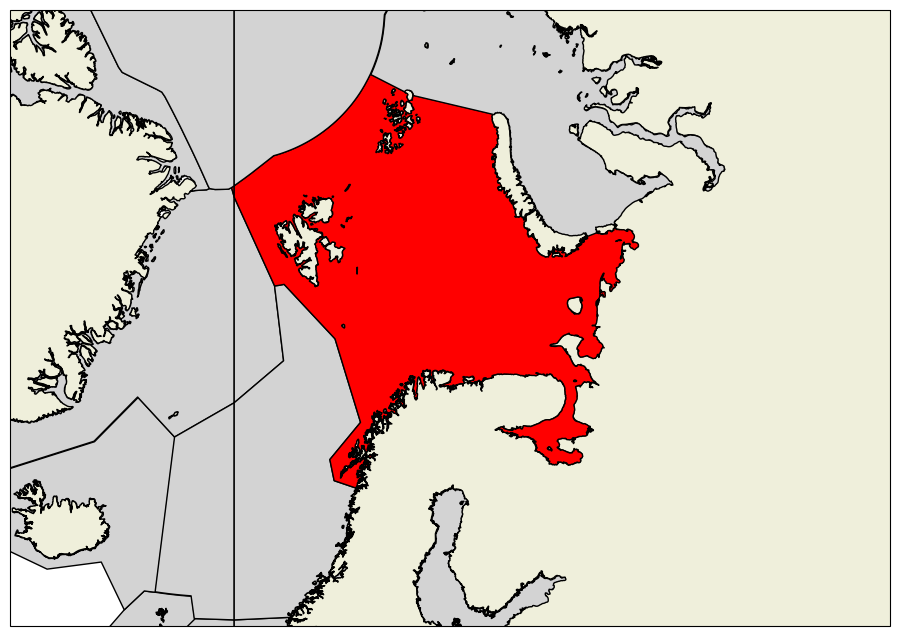

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_uas.nc
Working on LME: Barents Sea
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp245_uas.nc
Working on LME: Barents Sea
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_uas.nc
Working on LME: Barents Sea
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5-CanOE/CMIP6_CanESM5-CanOE_r1i1p2f1_ssp245_uas.nc
Working on LME: Barents Sea
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_uas.nc
Working on LME: Barents Sea
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_uas.nc
Working on LME: Ba

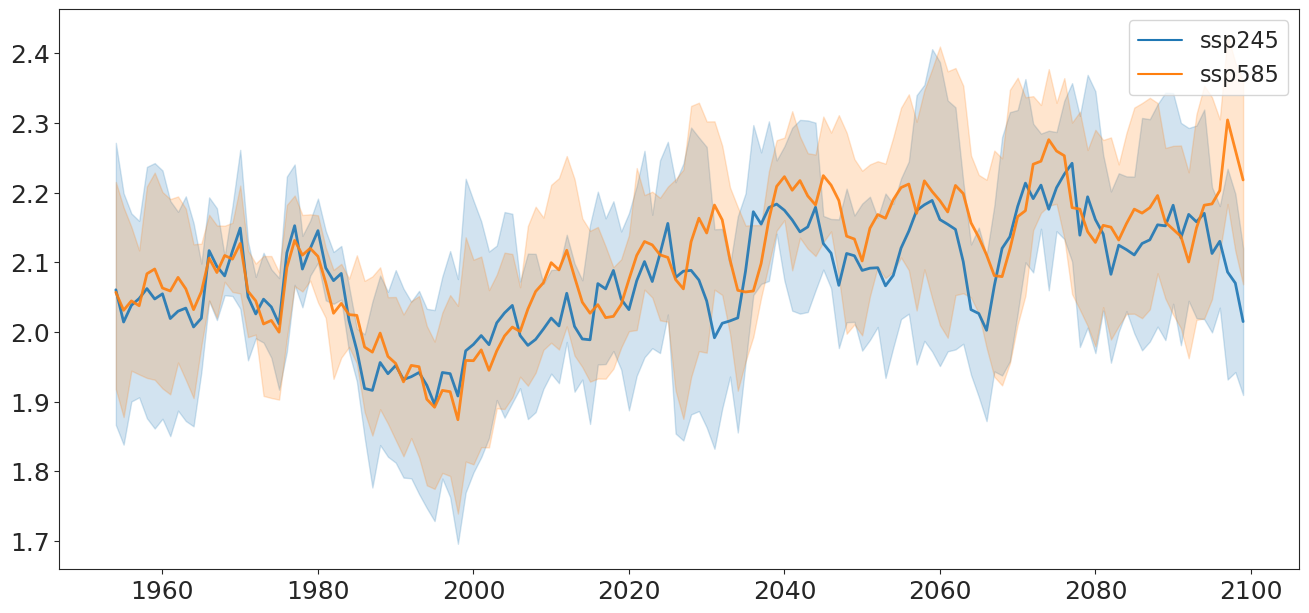

Working on LME: Northern Bering - Chukchi Seas
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


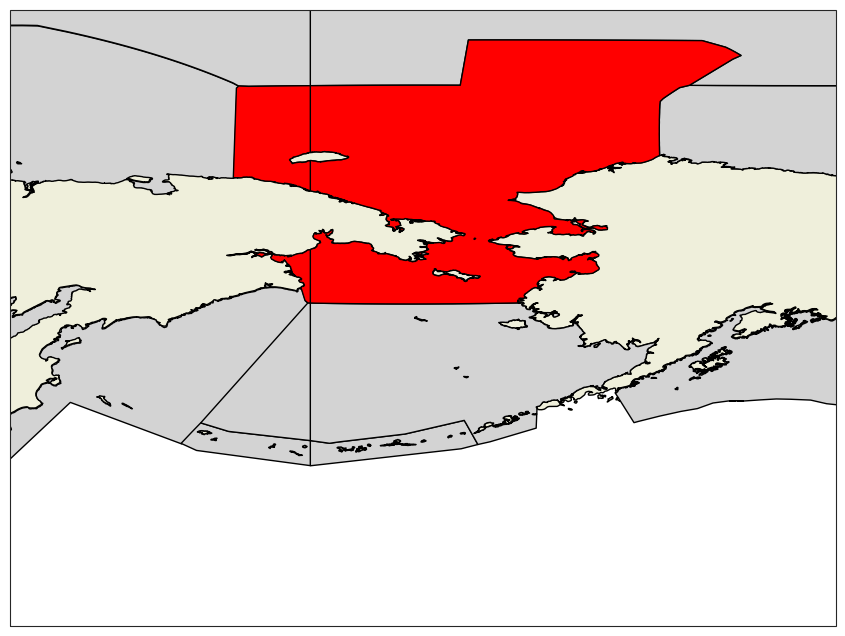

Working on LME: Northern Bering - Chukchi Seas
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


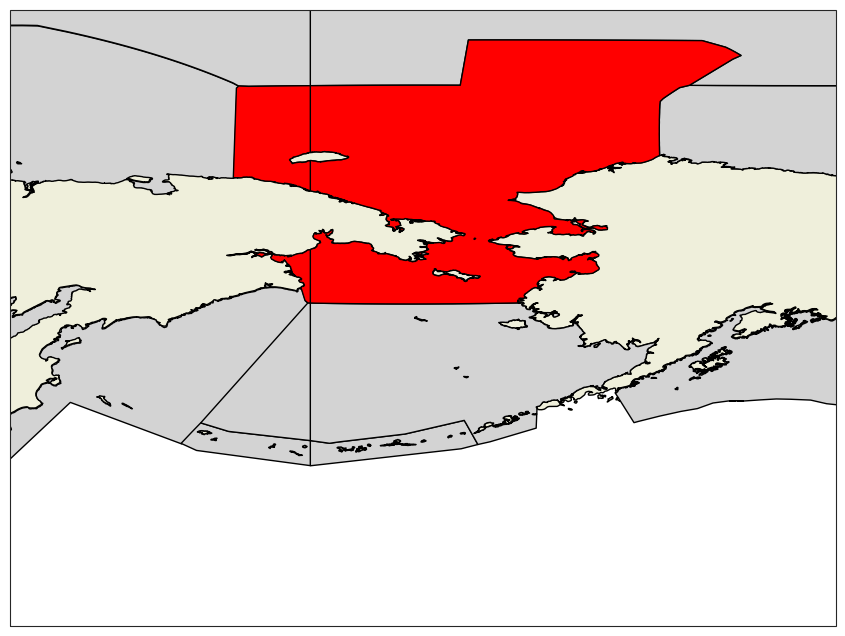

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_uas.nc
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp245_uas.nc
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_uas.nc
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5-CanOE/CMIP6_CanESM5-CanOE_r1i1p2f1_ssp245_uas.nc
Working on LME: Northern Bering - Chukchi Seas
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_uas.nc
Working on LME: Northern Bering - Chukchi

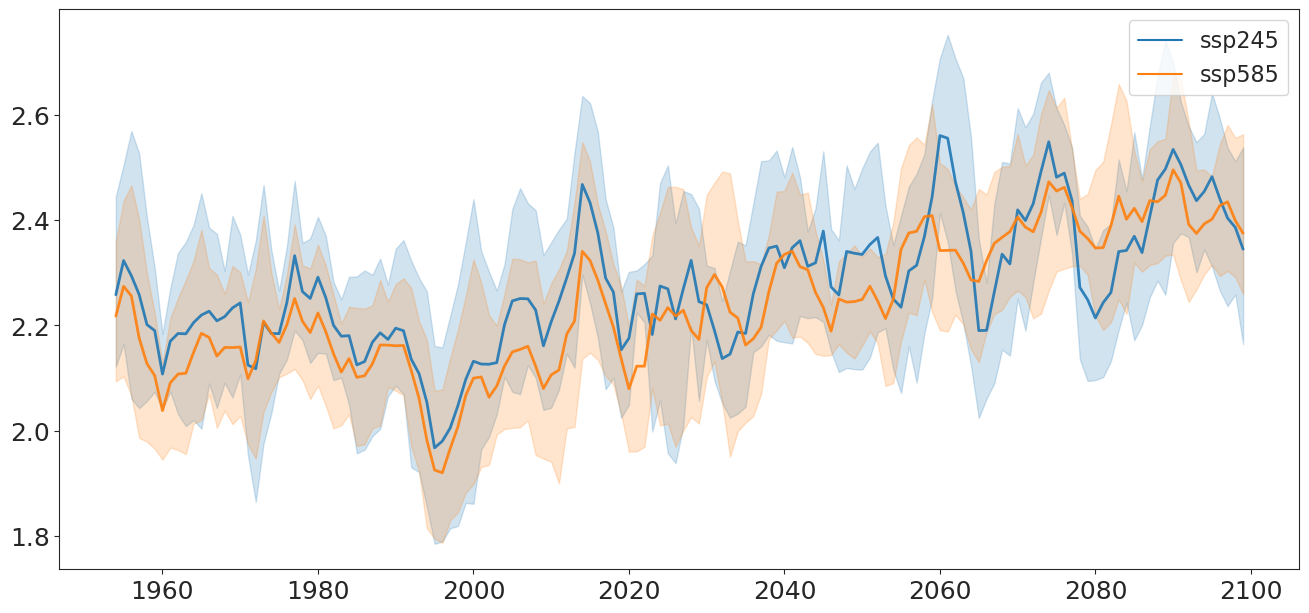

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


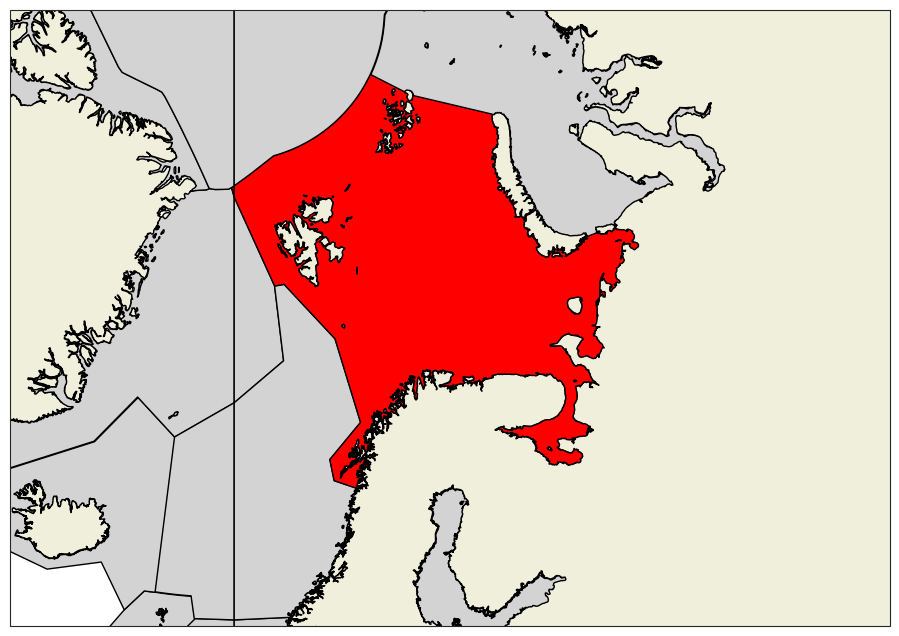

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r2i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r3i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp245_tos.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_tos.nc

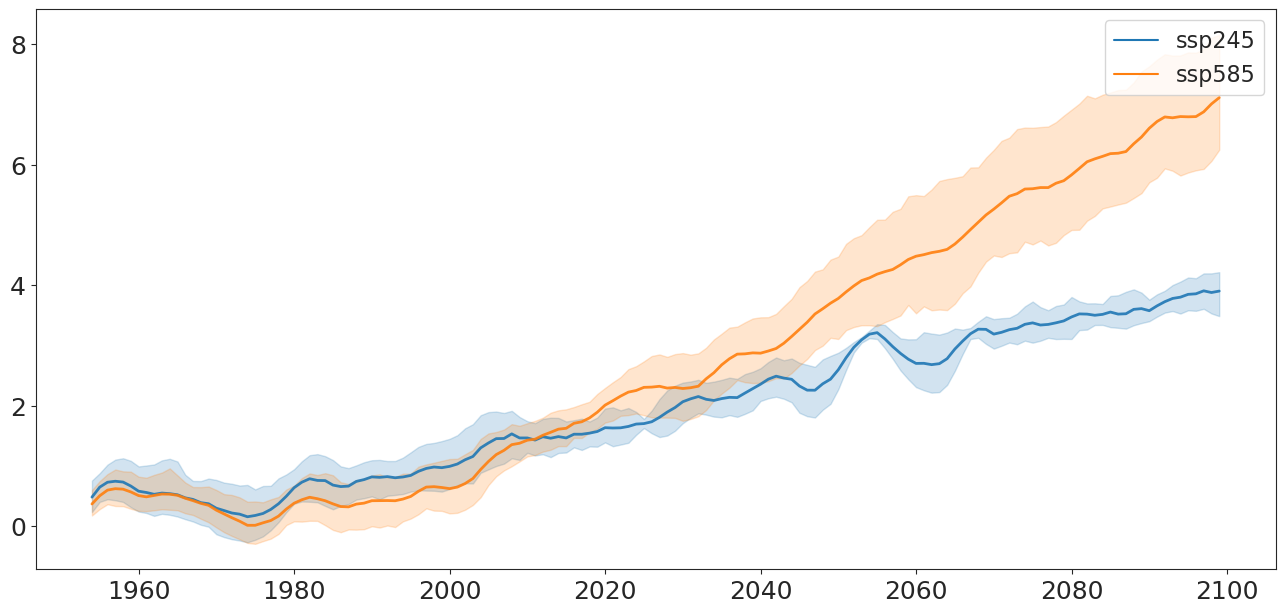

Working on LME: Northern Bering - Chukchi Seas
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


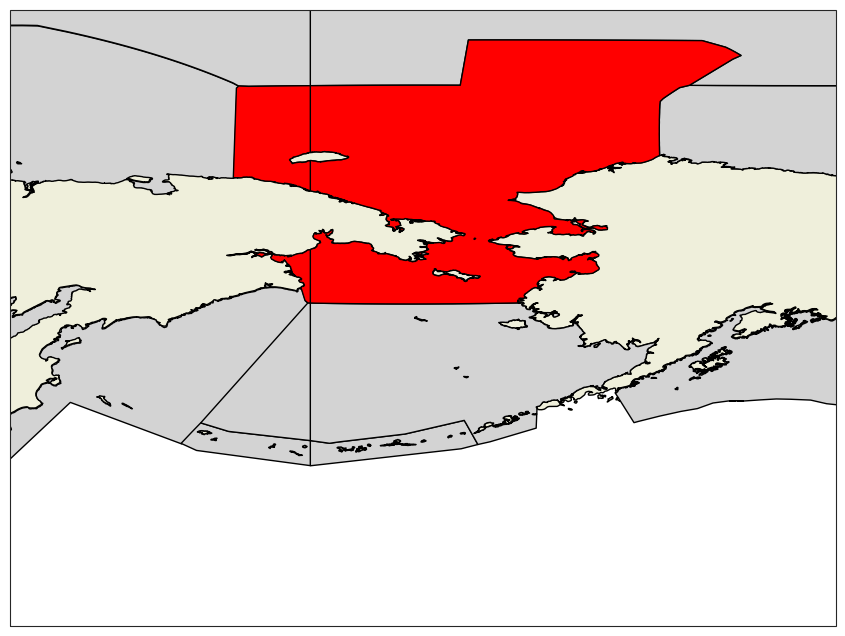

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r2i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r3i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp245_tos.nc
Working on LME: Northern Bering - Chukchi Seas
Crea

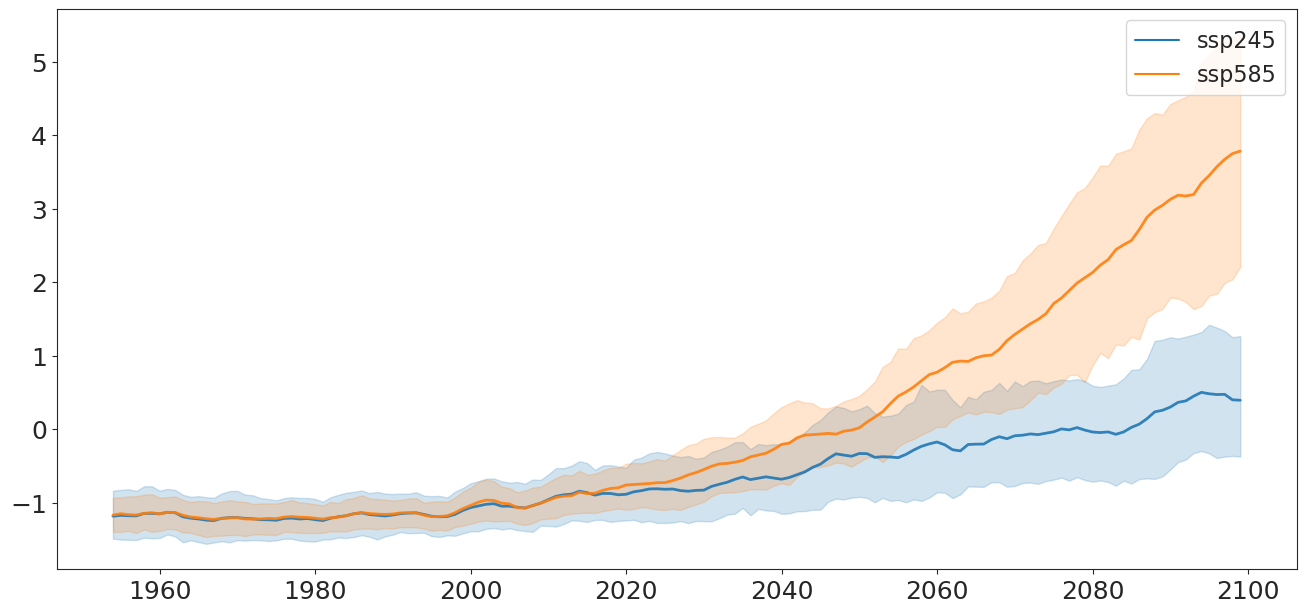

Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp245_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp585_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp585_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp585_ph.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/CanESM5-CanOE/CMIP6_CanESM5-CanOE_

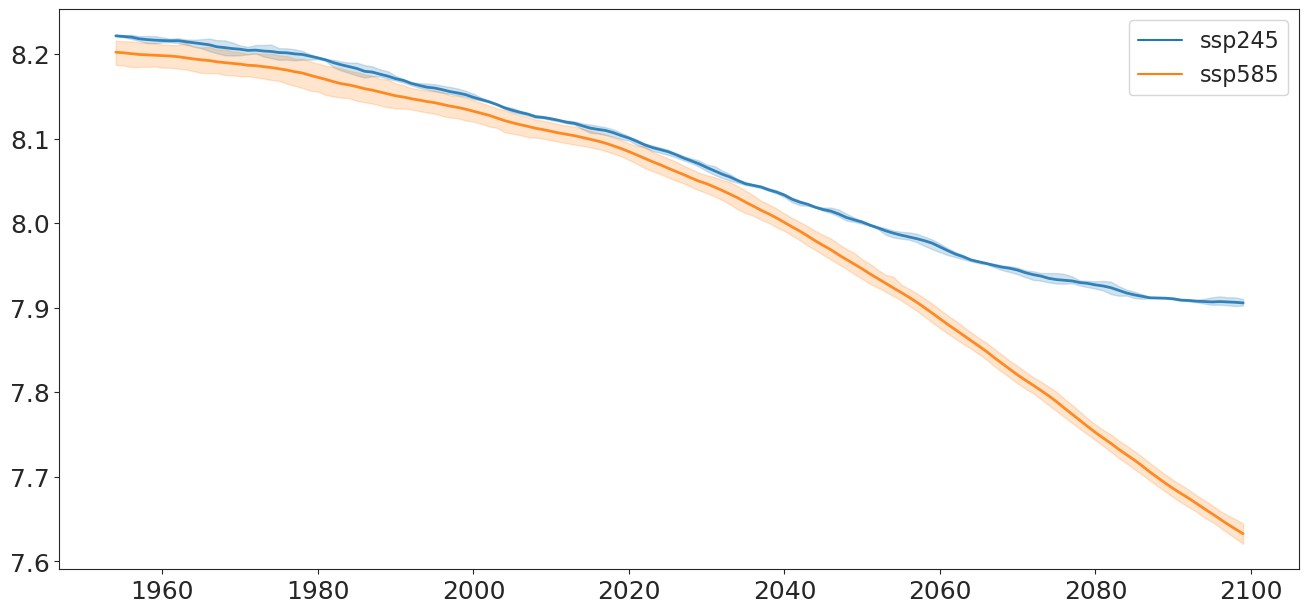

Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_ph.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp245_ph.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp245_ph.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp585_ph.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r2i1p1f1_ssp585_ph.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r3i1p1f1_ssp585_ph.nc
Working on

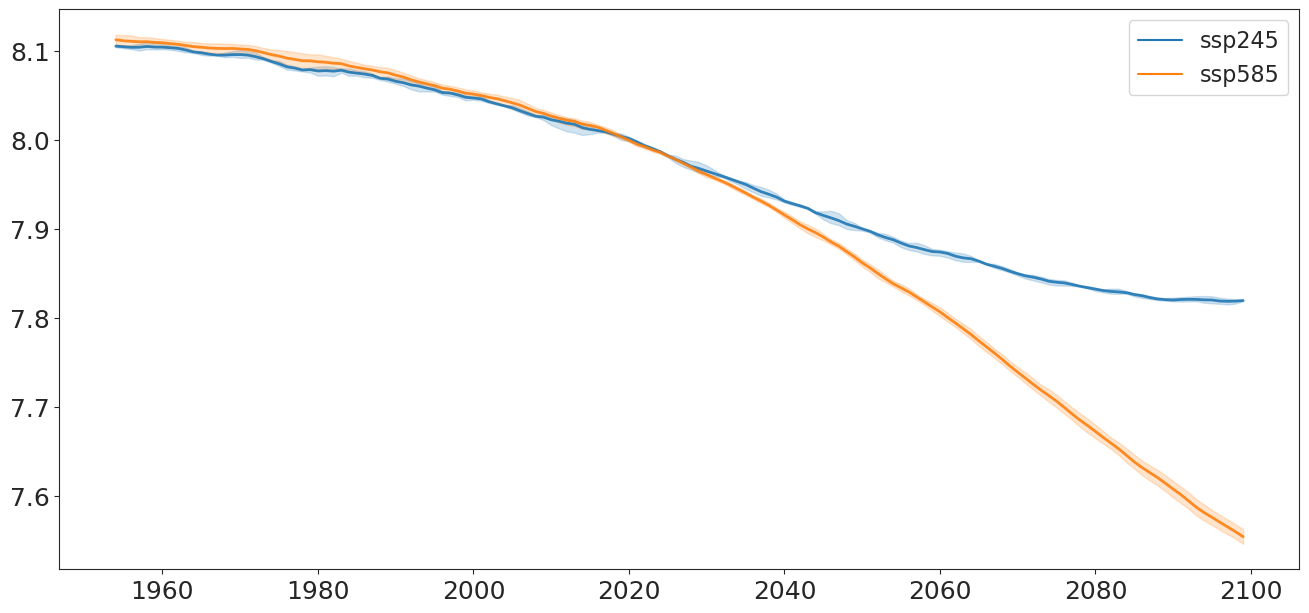

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


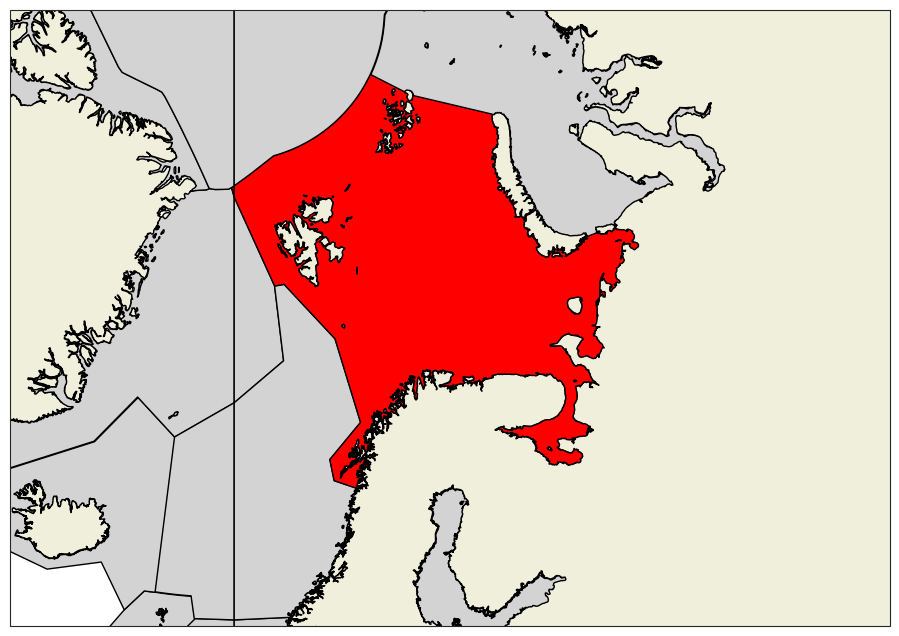

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp245_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5-CanOE/CMIP6_CanESM5-CanOE_r1i1p2f1_ssp245_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_clt.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp585_clt.nc
Working on LME: Barents

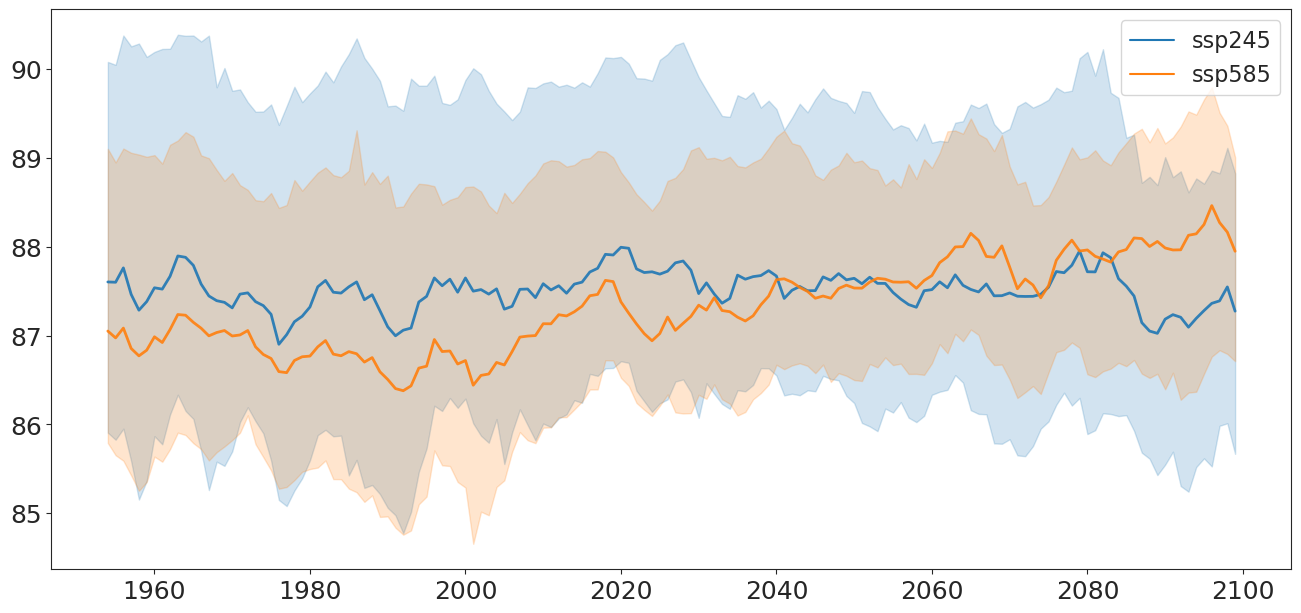

Working on LME: Northern Bering - Chukchi Seas
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


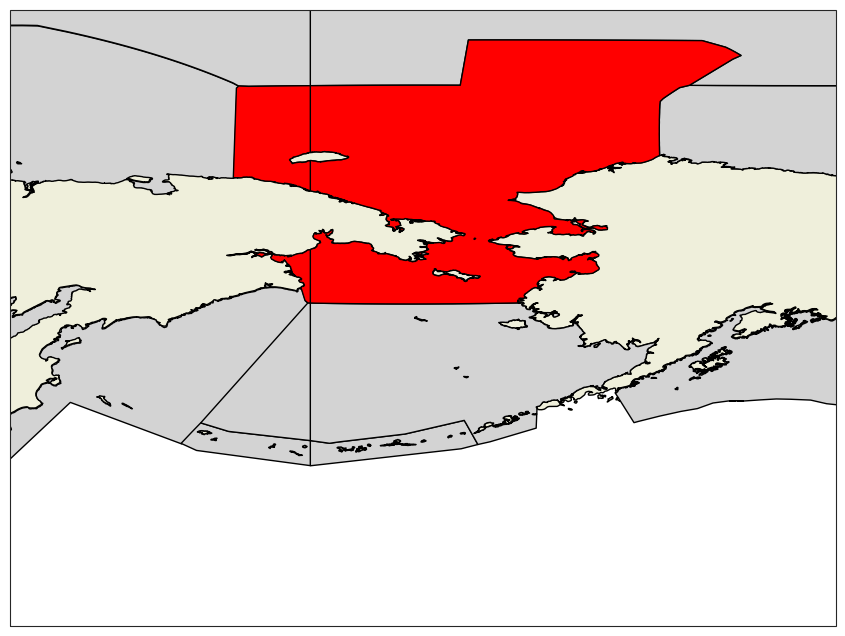

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp245_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5-CanOE/CMIP6_CanESM5-CanOE_r1i1p2f1_ssp245_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_clt.nc
Working on LME: Northern Bering - Chukchi Seas
Created datafram

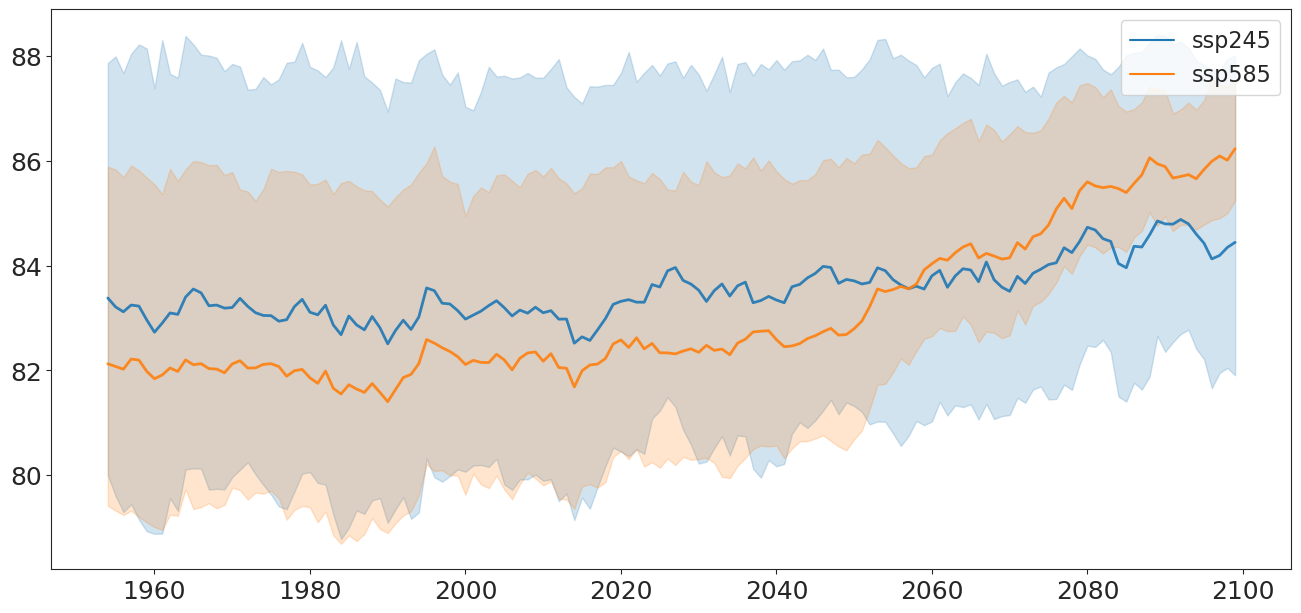

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


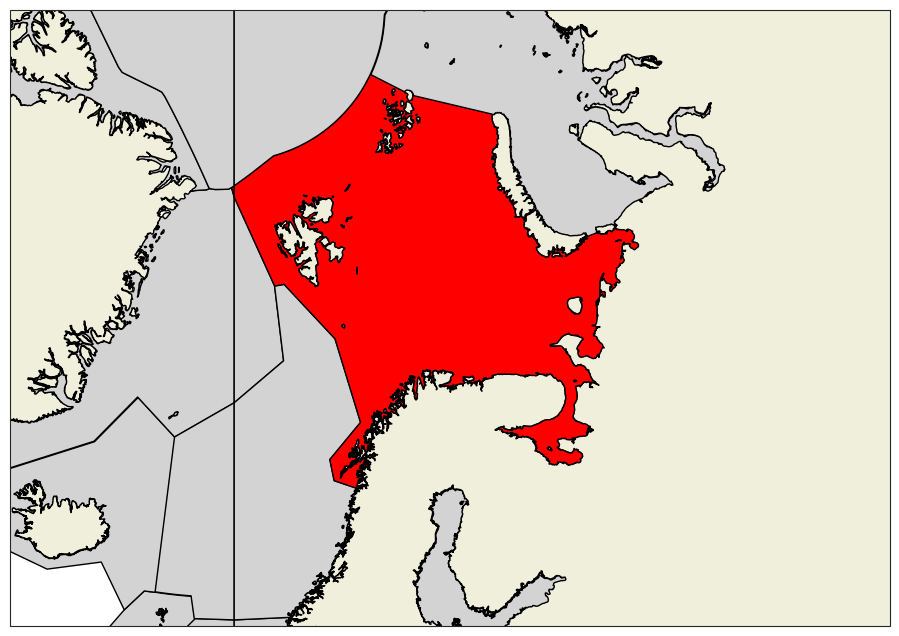

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_sithick.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_sithick.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_sithick.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_sithick.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp585_sithick.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp585_sithick.nc
            spatial_ref   sithick     model_name  roll_mean  roll_median  \
time                                          

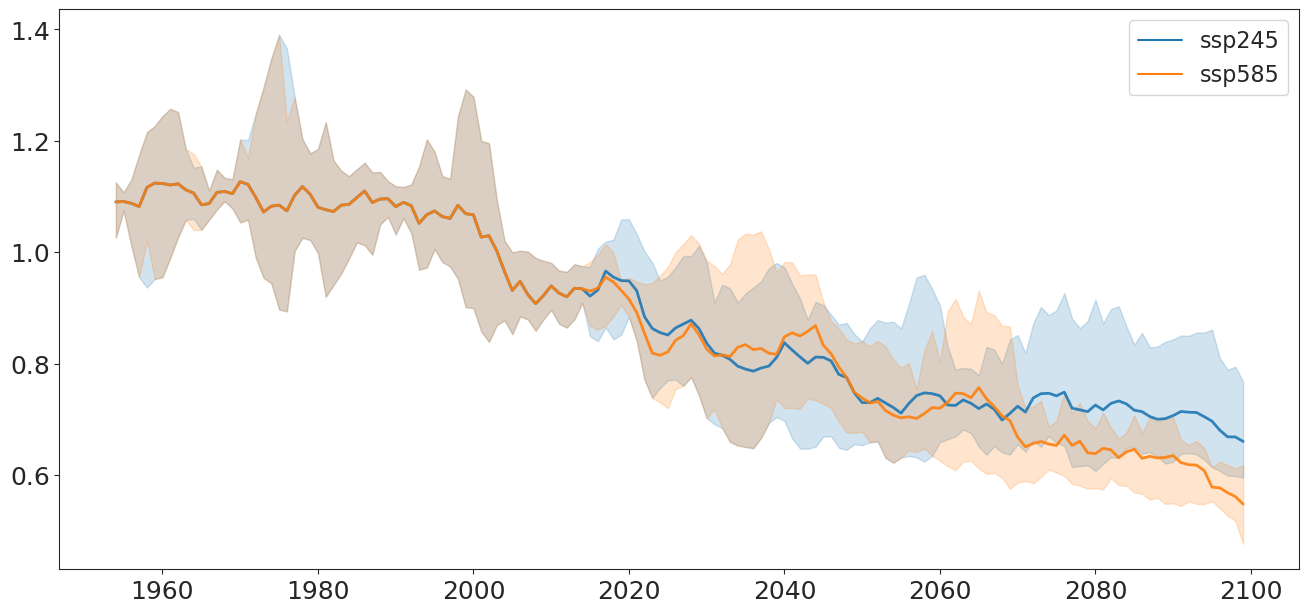

Working on LME: Northern Bering - Chukchi Seas
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


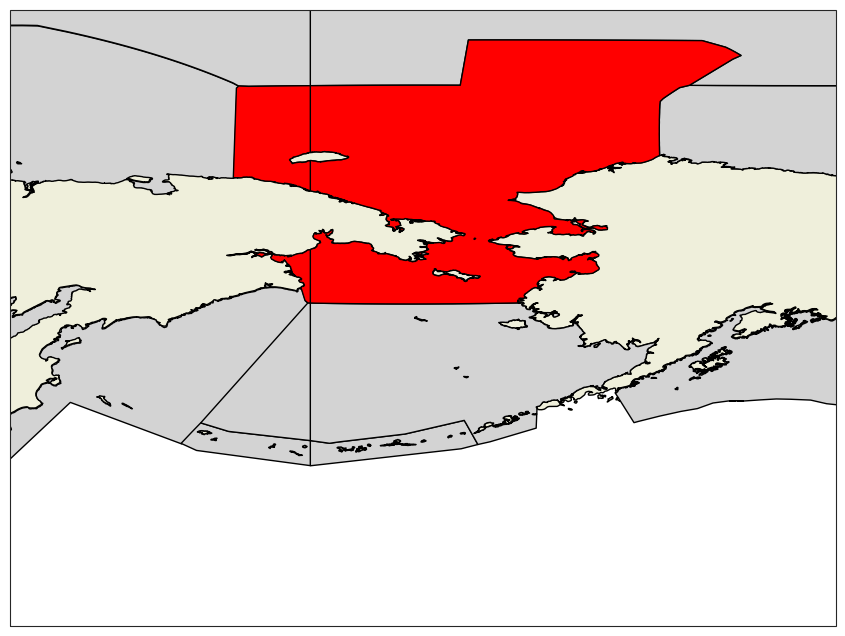

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_sithick.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_sithick.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_sithick.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_sithick.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp585_sithick.nc
Working on LME: Northern Bering - Chukchi Seas
Created dataframe of file: ../oceanography/cmip6/light/ssp585/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp585_sithick.nc
            spatial_ref   s

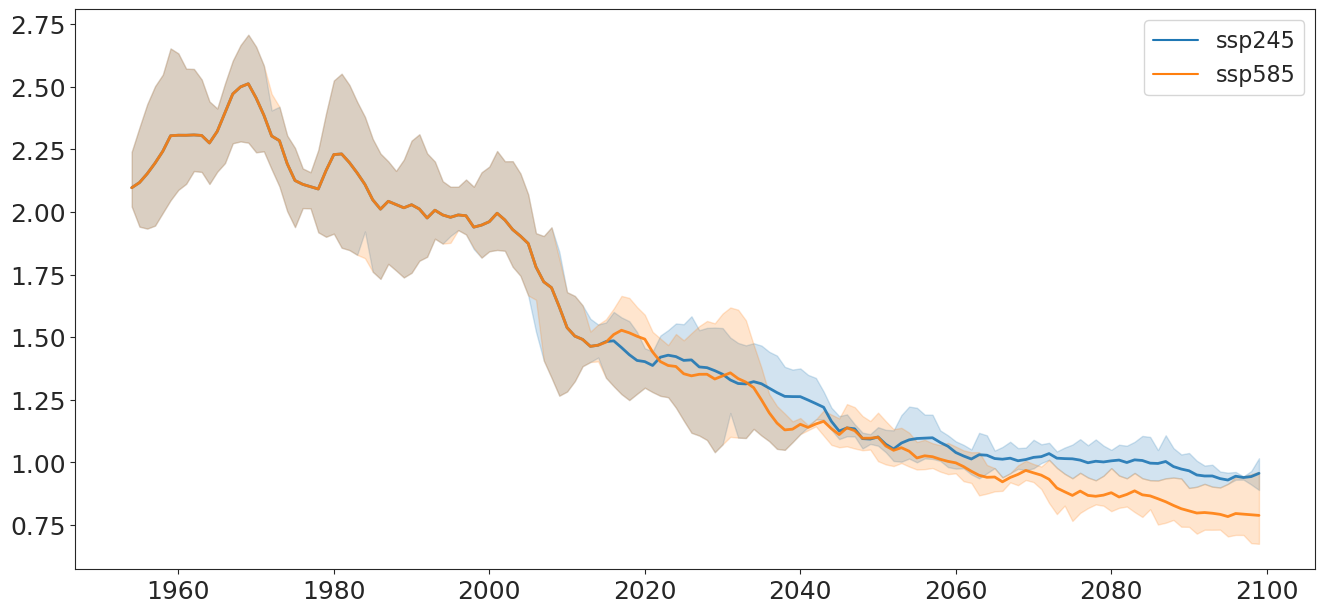

Working on LME: Barents Sea
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


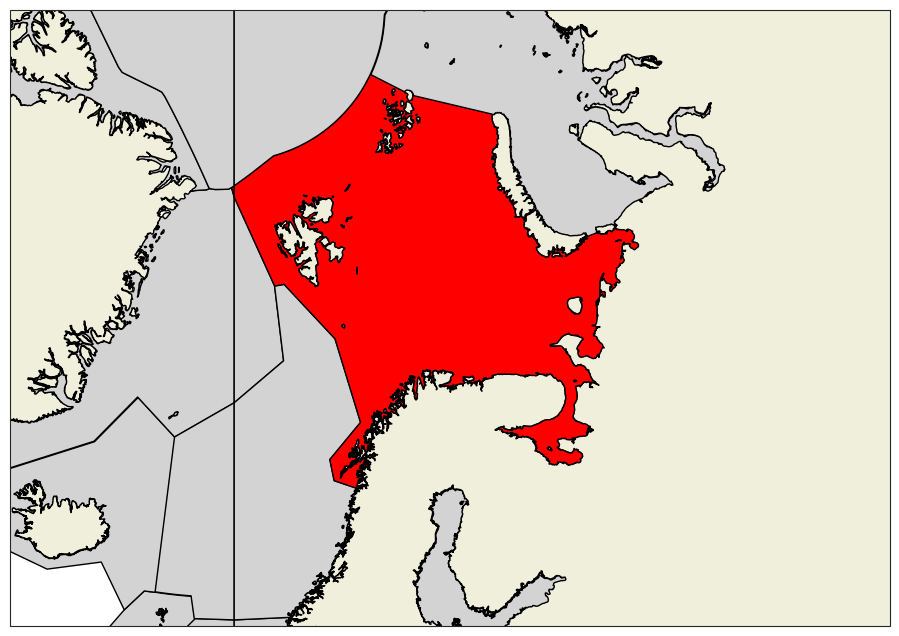

Created dataframe of file: ../oceanography/cmip6/light/ssp245/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp245_siconc.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/CanESM5/CMIP6_CanESM5_r1i1p1f1_ssp245_siconc.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-LR/CMIP6_MPI-ESM1-2-LR_r1i1p1f1_ssp245_siconc.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp245/MPI-ESM1-2-HR/CMIP6_MPI-ESM1-2-HR_r1i1p1f1_ssp245_siconc.nc
Working on LME: Barents Sea
Created dataframe of file: ../oceanography/cmip6/light/ssp585/ACCESS-ESM1-5/CMIP6_ACCESS-ESM1-5_r1i1p1f1_ssp585_siconc.nc
Working on LME: Barents Sea


In [ ]:
%%time
scenarios=["ssp245","ssp585"]
member_range=3
frequency="A"
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                           range(member_range)
                           for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]
period="1950-01-01-2099-12-16"
start_time="1950-01-01"
end_time="2099-12-16"

models=["ACCESS-ESM1-5","CanESM5","MPI-ESM1-2-LR","CanESM5-CanOE","UKESM1-O-LL","MPI-ESM1-2-HR"]
ds_var_names=["velocity","tos","ph","clt", "sithick", "siconc", "tas"] #["velocity"]
#ds_var_names=["tas"]

LMES=['California Current','East Bering Sea','Gulf of Alaska',
      'Northern Bering - Chukchi Seas','West Bering Sea','Sea of Japan',
      'Oyashio Current','Kuroshio Current','East China Sea',
      'South China Sea','Sea of Okhotsk','Yellow Sea',
      'Aleutian Islands']

LMES=['Barents Sea','Northern Bering - Chukchi Seas','Central Arctic']
LMES=['Barents Sea','Northern Bering - Chukchi Seas']

for var_name in ds_var_names:
    for LME in LMES:
        ds_list=[]
        models_dict={}
        create_maps=True
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            for model in models:
                for ensemble_id in ensemble_ids:
                    if var_name not in ["velocity"]:
                        fname = "../oceanography/cmip6/light/{}/{}/CMIP6_{}_{}_{}_{}.nc".format(scenario,model,
                                                                                             model,
                                                                                             ensemble_id,
                                                                                             scenario,
                                                                                             var_name)
                        fname2=None
                    else:
                        fname = "../oceanography/cmip6/light/{}/{}/CMIP6_{}_{}_{}_{}.nc".format(scenario,model,
                                                                                         model,
                                                                                         ensemble_id,
                                                                                         scenario,
                                                                                         "uas")
                        fname2 = "../oceanography/cmip6/light/{}/{}/CMIP6_{}_{}_{}_{}.nc".format(scenario,model,
                                                                                         model,
                                                                                         ensemble_id,
                                                                                         scenario,
                                                                                         "vas")
                    
                    df, models_dict = get_area_averaged_ds(fname, model,scenario, ensemble_id,var_name, LME, create_maps, frequency, models_dict,fname2)
                    create_maps=False
                    if df is not None:
                       
                        ds_list.append(df)
                        print("Created dataframe of file: {}".format(fname))
                        

        if len(ds_list) > 0:
            df = pd.concat(ds_list)
            print(df.head())
            create_summary_table(models_dict, LME)

            sns.set_style("ticks")
            f=plt.figure(figsize=(16, 16))
            gs = f.add_gridspec(2, 1)
            ax = f.add_subplot(gs[0, 0])

            sns.set_palette("tab10")
            for y in [2050,2095]:
                for ssp in ["ssp245","ssp585"]:
                    df_2050=df[(df.index.year==y) & (df["model_scenario"]==ssp)]
                    df_2050.describe().to_csv("CMIP6_RACARCTIC_{}_{}_{}_{}.csv".format(var_name,LME,y,ssp))
                   

            b=sns.lineplot(ax=ax, data=df, x=df.index, y=df["roll_mean"],
                         hue=df["model_scenario"],
                         alpha=.9, ci=95,linewidth=2)                
            b.tick_params(labelsize=18)
            b.set_xlabel("",fontsize=10)
            b.set_ylabel("",fontsize=10)
            plt.legend(loc="upper right", frameon=True, fontsize=16)
            
            if not os.path.exists("Figures"):
                os.makedirs("Figures")
            plotfile="Figures/CMIP6_lightpaper_{}_{}.png".format(var_name,LME)
            print("Created figure {}".format(plotfile))
            plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')

            plt.show()

        df=pd.DataFrame()
        ds_list=[]